# Recursive QAOA

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import json
import os
import joblib

from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params, Hamiltonian
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA, RQAOA
from openqaoa.problems.problem import QUBO, MaximumCut, MinimumVertexCover

In [2]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)

sns.axes_style("whitegrid")
sns.set_context("paper", font_scale=2.5)

In [3]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [4]:
def run_grid_search(qubo):
    hamiltonian = qubo.hamiltonian
    
    # restricted for udR graphs:
    betas = np.linspace(0, np.pi/2, 50)
    gammas = np.linspace(0, 3*np.pi, 300)
    
    cost_landscape = np.zeros((betas.size, gammas.size), dtype=float)
    
    for i, beta in enumerate(betas):
        for j, gamma in enumerate(gammas):
            variational_params = [beta, gamma]
            cost_landscape[i,j] = energy_expectation_analytical(variational_params, hamiltonian)
            
    loc_min = np.argwhere(cost_landscape == np.min(cost_landscape))
    beta_min = betas[loc_min[0][0]]
    gamma_min = gammas[loc_min[0][1]]
    
    return cost_landscape, beta_min, gamma_min
    

In [5]:
def plot_landscape(cost_landscape, betas, gammas):

    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    #plt.savefig("cost_landscape_sigma={}_mu={}.png".format(sigma, mu))
    plt.show()
    

## Run experiment: adaptive vs custom with perfect optimizer

In [38]:
def run_Rqaoa_experiment_rqaoa_type(sigma, graph_seed, optimizer, rqaoa_type, experiment_name='Maxcut_w3R_grid_search'):  
    
    mu = 5.0
    k = 3
    n = 12
    
    # rqaoa_type contains the method for the elimination schedule followed by the number of steps or n_max for the custom and adaptive methods respectively
    
    if rqaoa_type[:-2] == "custom":
        steps = int(rqaoa_type[-1])
    elif rqaoa_type[:-2] == "adaptive":
        nMax = int(rqaoa_type[-1])
    
    # experiment_name = name of the folder to contain all data for this experiment
    # structure of the name: problem_typeOfGraph[optional]_variableToInvestigate
    
    g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=graph_seed, weighted=True, mu=mu, sigma=sigma, biases=False) 

    # Define te problem and translate it into a binary Qubo.
    maxcut_prob = MaximumCut(g)
    maxcut_qubo = maxcut_prob.get_qubo_problem()

    
    # Define the RQAOA object 
    R = RQAOA()

    # Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3
    if rqaoa_type[:-2] == "custom":
        R.set_rqaoa_parameters(n_cutoff = 3, steps = steps, rqaoa_type = "custom")
    elif rqaoa_type[:-2] == "adaptive":
        R.set_rqaoa_parameters(n_cutoff = 3, n_max = nMax, rqaoa_type = "adaptive")
    elif rqaoa_type[:-2] == "vanilla":
        R.set_rqaoa_parameters(n_cutoff = 3, steps = 1, rqaoa_type = 'custom')

    ## Setting up the QAOA properties

    # Set the properties you want - These values are actually the default ones!
    #R.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
    
    # perform a grid search for initializing very close to (hopefully the global) minimum
    # THE QUBO I PASS IN THIS FUNCTION MUST CHANGE!!!
    cost_landscape, init_beta, init_gamma = run_grid_search(qubo = maxcut_qubo)
    
    R.set_circuit_properties(p=1, init_type='custom', variational_params_dict={"betas":[init_beta], "gammas":[init_gamma]}, mixer_hamiltonian='x')

    # Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
    device = create_device(location='local', name='vectorized')
    R.set_device(device)

    # Set the classical method used to optimiza over QAOA angles and its properties
    R.set_classical_optimizer(method=optimizer, 
                              optimizer_options = {"stepsize" : 0.001},
                              tol=10**(-6), maxfev=100, maxiter=10, 
                              jac='finite_difference',
                              #parameter shift
                              hess='finite_difference',
                              optimization_progress=False, 
                              cost_progress=True, parameter_log=True)


    # Compile problem instance on RQAOA, just like with QAOA
    R.compile(maxcut_qubo)
    
    R.optimize()
    
    try: 
        os.mkdir(experiment_name) 
    except OSError as error: 
        pass # TODO not sure if the best way to handle this  
    
    # TODO save in the backup folder directly
    
    R.results.dump("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__type_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, rqaoa_type))
    

    
# What if in a couple of days I decide that I want to vary the cutoff too? 
## Then I will have to add this to the name of the file and then it will get cumbursome to compare files from different folders


# Run experiment

In [55]:
sigma_list = [0.1, 1, 10, 100]
#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]
optimizer_list = ["rmsprop"]
graph_seed_list = [1, 2, 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]  

rqaoa_type_list = ["custom-4", "adaptive-8"]

joblib.Parallel(n_jobs=16)(joblib.delayed(run_Rqaoa_experiment_rqaoa_type)(sigma, graph_seed, optimizer, rqaoa_type) for sigma in sigma_list for graph_seed in graph_seed_list for optimizer in optimizer_list for rqaoa_type in rqaoa_type_list)
 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Analyze Experiment

In [56]:
experiment_name = 'Maxcut_w3R_grid_search' # to be used as a name for the folder containing all jsons for this experiment 
# structure of the name: problem_typeOfGraph[optional]_variableToInvestigate

mu = 5.0

sigma_list = [0.1, 1, 10, 100]
#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]
optimizer_list = ["rmsprop"]
graph_seed_list = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
rqaoa_type_list = ["vanilla", "custom-2", "adaptive-4", "custom-3", "adaptive-6", "custom-4", "adaptive-8"]

data = []


for sigma in sigma_list:
    print("Sigma=", sigma) 
    for graph_seed in graph_seed_list:
        print("graph_seed=", graph_seed)
        for optimizer in optimizer_list:
            print("Optimizer=", optimizer)
            for rqaoa_type in rqaoa_type_list:
                print("rqaoa_type=", rqaoa_type)
                
                
                # Opening JSON file
                f = open("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__type_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, rqaoa_type))
    
                
                print(f)
                # returns JSON object as a dictionary
                opt_results = json.load(f)

                # construct the original problem Hamiltonian from the initial QAOA 
                qaoa_init = opt_results['intermediate_steps'][0]['QAOA']
                terms = []
                for i in range(0, len(qaoa_init['cost_hamiltonian']['terms'])):
                    terms.append(qaoa_init['cost_hamiltonian']['terms'][i]['qubit_indices'])
                weights = qaoa_init['cost_hamiltonian']['coeffs']
                const = qaoa_init['cost_hamiltonian']['constant']

                cost_hamiltonian = Hamiltonian.classical_hamiltonian(terms, weights, const)

                analytical_energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

                # Calculate the approx. ratio
                optimization_energy = list(opt_results['solution'].values())[0]

                r = np.abs(optimization_energy) / np.abs(analytical_energy)

                # Extract other params
                optimization_schedule = list(opt_results['schedule'])

                avr_schedule = np.average(optimization_schedule)

                data.append([sigma, graph_seed, rqaoa_type, optimizer, r, optimization_schedule, avr_schedule])

                f.close()


Sigma= 0.1
graph_seed= 1
Optimizer= rmsprop
rqaoa_type= vanilla
<_io.TextIOWrapper name='Maxcut_w3R_grid_search/mu_5.0__sigma_0.1__graphSeed_1_optimizer_rmsprop__type_vanilla.json' mode='r' encoding='UTF-8'>
rqaoa_type= custom-2
<_io.TextIOWrapper name='Maxcut_w3R_grid_search/mu_5.0__sigma_0.1__graphSeed_1_optimizer_rmsprop__type_custom-2.json' mode='r' encoding='UTF-8'>
rqaoa_type= adaptive-4
<_io.TextIOWrapper name='Maxcut_w3R_grid_search/mu_5.0__sigma_0.1__graphSeed_1_optimizer_rmsprop__type_adaptive-4.json' mode='r' encoding='UTF-8'>
rqaoa_type= custom-3
<_io.TextIOWrapper name='Maxcut_w3R_grid_search/mu_5.0__sigma_0.1__graphSeed_1_optimizer_rmsprop__type_custom-3.json' mode='r' encoding='UTF-8'>
rqaoa_type= adaptive-6
<_io.TextIOWrapper name='Maxcut_w3R_grid_search/mu_5.0__sigma_0.1__graphSeed_1_optimizer_rmsprop__type_adaptive-6.json' mode='r' encoding='UTF-8'>
rqaoa_type= custom-4
<_io.TextIOWrapper name='Maxcut_w3R_grid_search/mu_5.0__sigma_0.1__graphSeed_1_optimizer_rmsprop__t

In [57]:
df = pd.DataFrame(np.array(data), columns=['sigma', 'graph_seed', 'rqaoa_type', 'optimizer', 'r', 'schedule', 'avr_schedule'])

df['sigma'] = df['sigma'].astype(float)
df['graph_seed'] = df['graph_seed'].astype(int)
df['rqaoa_type'] = df['rqaoa_type'].astype(str)
df['optimizer'] = df['optimizer'].astype(str)
df['r'] = df['r'].astype(float)
df['avr_schedule'] = df['avr_schedule'].astype(float)


df.to_csv("{}_more_methods.csv".format(experiment_name))

/tmp/ipykernel_13040/1912235271.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(data), columns=['sigma', 'graph_seed', 'rqaoa_type', 'optimizer', 'r', 'schedule', 'avr_schedule'])


In [58]:
df


,sigma,graph_seed,rqaoa_type,optimizer,r,schedule,avr_schedule
0,0.1,1,vanilla,rmsprop,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",1.00
1,0.1,1,custom-2,rmsprop,1.000000,"[2, 2, 2, 2, 1]",1.80
2,0.1,1,adaptive-4,rmsprop,1.000000,"[2, 3, 3, 1]",2.25
3,0.1,1,custom-3,rmsprop,1.000000,"[3, 3, 3]",3.00
4,0.1,1,adaptive-6,rmsprop,1.000000,"[2, 3, 3, 1]",2.25
...,...,...,...,...,...,...,...
2795,100.0,100,adaptive-4,rmsprop,1.000000,"[2, 1, 2, 2, 1, 1]",1.50
2796,100.0,100,custom-3,rmsprop,0.833929,"[3, 3, 3]",3.00
2797,100.0,100,adaptive-6,rmsprop,0.992168,"[4, 2, 1, 2]",2.25
2798,100.0,100,custom-4,rmsprop,0.992168,"[4, 4, 1]",3.00


In [ ]:
experiment_name

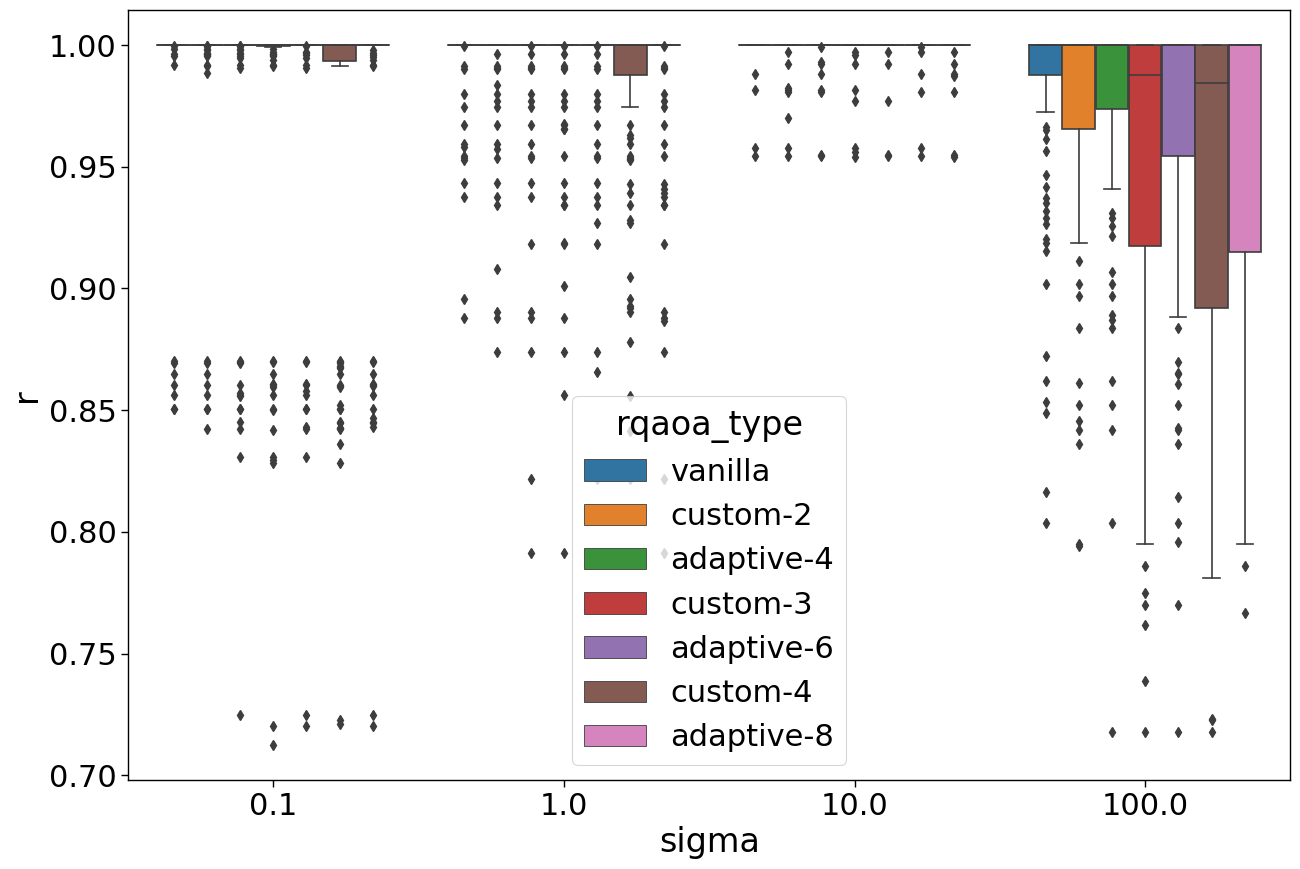

In [59]:
#plt.xscale('log')
#plt.ylim(0, 1)

sns.boxplot(data = df, x = 'sigma', y ='r', hue='rqaoa_type') # averaging both over graph instances and initial seeds
plt.savefig("{}_more_methods.png".format(experiment_name))

#sns.boxplot(data = df, x = 'sigma', y ='r', hue='init_seed') # shows which initialization is the best on average
#plt.savefig("{}_init_seed.png".format(experiment_name))


### Average elimination in the adaptive method 

In [52]:
ada_df = df[df['rqaoa_type'] == "adaptive-6"]
ada_df

,sigma,graph_seed,rqaoa_type,optimizer,r,schedule,avr_schedule
4,0.1,1,adaptive-6,rmsprop,1.000000,"[2, 3, 3, 1]",2.25
9,0.1,2,adaptive-6,rmsprop,1.000000,"[3, 2, 2, 2]",2.25
14,0.1,3,adaptive-6,rmsprop,1.000000,"[3, 2, 1, 1, 2]",1.80
19,0.1,4,adaptive-6,rmsprop,1.000000,"[3, 3, 2, 1]",2.25
24,0.1,5,adaptive-6,rmsprop,0.856226,"[4, 2, 2, 1]",2.25
...,...,...,...,...,...,...,...
1979,100.0,96,adaptive-6,rmsprop,1.000000,"[3, 2, 2, 2]",2.25
1984,100.0,97,adaptive-6,rmsprop,0.914934,"[3, 4, 1, 1]",2.25
1989,100.0,98,adaptive-6,rmsprop,1.000000,"[4, 3, 2]",3.00
1994,100.0,99,adaptive-6,rmsprop,0.883582,"[4, 3, 2]",3.00


In [53]:
ada_df_01 = ada_df[df['sigma'] == 0.1]
ada_df_1 = ada_df[df['sigma'] == 1]
ada_df_10 = ada_df[df['sigma'] == 10]
ada_df_100 = ada_df[df['sigma'] == 100]

/tmp/ipykernel_13040/4133086091.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ada_df_01 = ada_df[df['sigma'] == 0.1]
/tmp/ipykernel_13040/4133086091.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ada_df_1 = ada_df[df['sigma'] == 1]
/tmp/ipykernel_13040/4133086091.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ada_df_10 = ada_df[df['sigma'] == 10]
/tmp/ipykernel_13040/4133086091.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ada_df_100 = ada_df[df['sigma'] == 100]


In [54]:
avr_schedule_01 = ada_df_01["avr_schedule"].mean()
print(avr_schedule_01)
avr_schedule_1 = ada_df_1["avr_schedule"].mean()
print(avr_schedule_1)
avr_schedule_10 = ada_df_10["avr_schedule"].mean()
print(avr_schedule_10)
avr_schedule_100 = ada_df_100["avr_schedule"].mean()
print(avr_schedule_100)

2.28
2.1975
2.373
2.2920000000000003


### Code profiling: Time it!

In [ ]:
%%timeit


mu = 5.0
k = 3
n = 12
steps = 2
graph_seed = 1
sigma=1
optimizer = "cobyla"

g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=graph_seed, weighted=True, mu=mu, sigma=sigma, biases=False) 

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()


# Define the RQAOA object 
R = RQAOA()

# Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3

# vanilla
R.set_rqaoa_parameters(n_cutoff = 3, steps = 1, rqaoa_type = 'custom')

R.set_circuit_properties(p=1, init_type='ramp', mixer_hamiltonian='x')

# Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
device = create_device(location='local', name='vectorized')
R.set_device(device)

# Set the classical method used to optimiza over QAOA angles and its properties
R.set_classical_optimizer(method=optimizer, 
                          optimizer_options = {"stepsize" : 0.01},
                          tol=10**(-3), maxfev=2000, maxiter=2000, 
                          jac='finite_difference',
                          #parameter shift
                          hess='finite_difference',
                          optimization_progress=False, 
                          cost_progress=True, parameter_log=True)

# Compile problem instance on RQAOA, just like with QAOA
R.compile(maxcut_qubo)

R.optimize()

In [ ]:
%%timeit

mu = 5.0
k = 3
n = 12
steps = 2
graph_seed = 1
sigma=1
optimizer = "cobyla"

g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=graph_seed, weighted=True, mu=mu, sigma=sigma, biases=False) 

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()


# Define the RQAOA object 
R = RQAOA()

# Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3

R.set_rqaoa_parameters(n_cutoff = 3, steps = steps, rqaoa_type = "custom")

# Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
device = create_device(location='local', name='vectorized')
R.set_device(device)

# Set the classical method used to optimiza over QAOA angles and its properties
R.set_classical_optimizer(method=optimizer, 
                          optimizer_options = {"stepsize" : 0.01},
                          tol=10**(-3), maxfev=2000, maxiter=2000, 
                          jac='finite_difference',
                          #parameter shift
                          hess='finite_difference',
                          optimization_progress=False, 
                          cost_progress=True, parameter_log=True)

# Compile problem instance on RQAOA, just like with QAOA
R.compile(maxcut_qubo)

R.optimize()

In [ ]:
%%timeit


mu = 5.0
k = 3
n = 12
steps = 2
graph_seed = 1
sigma=1
optimizer = "cobyla"

g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=graph_seed, weighted=True, mu=mu, sigma=sigma, biases=False) 

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()


# Define the RQAOA object 
R = RQAOA()

# Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3


R.set_rqaoa_parameters(n_cutoff = 3, n_max = 2*steps, rqaoa_type = "adaptive")

R.set_circuit_properties(p=1, init_type='ramp', mixer_hamiltonian='x')

# Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
device = create_device(location='local', name='vectorized')
R.set_device(device)

# Set the classical method used to optimiza over QAOA angles and its properties
R.set_classical_optimizer(method=optimizer, 
                          optimizer_options = {"stepsize" : 0.01},
                          tol=10**(-3), maxfev=2000, maxiter=2000, 
                          jac='finite_difference',
                          #parameter shift
                          hess='finite_difference',
                          optimization_progress=False, 
                          cost_progress=True, parameter_log=True)

# Compile problem instance on RQAOA, just like with QAOA
R.compile(maxcut_qubo)

R.optimize()